# 1. 환경세팅

In [1]:
from IPython.display import clear_output 

#install magenta
!pip install magenta==2.1.0
#install visual_midi for visualization
!pip install visual_midi
#install for convert from midi to wav
!apt install fluidsynth

#download dataset and unzip
!wget https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0-midionly.zip
!unzip groove-v1.0.0-midionly.zip

#download groove checkpoint
!wget https://storage.googleapis.com/magentadata/models/music_vae/checkpoints/groovae_4bar.tar

clear_output()

## 사용된 라이브러리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from magenta.models.music_vae import MusicVAE
from magenta.models.music_vae import lstm_models
from magenta.models.music_vae import data
from magenta.models.music_vae.trained_model import TrainedModel
from magenta.models.music_vae import Config, update_config, configs
from magenta.common import merge_hparams
from magenta.scripts.convert_dir_to_note_sequences import convert_directory

from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

import note_seq

import warnings
warnings.filterwarnings(action='once')

## 시각화 함수

In [3]:
def visualization_midi(midi_path):
    preset = Preset(plot_width=850)
    plotter = Plotter(preset, plot_max_length_bar=4)
    pm = PrettyMIDI(midi_path)
    plotter.show_notebook(pm)

## 경로 변수

In [25]:
ROOT_PATH = './groove/'
RECORD_PATH = './groove.tfrecord'
RESULT_PATH = './result/'

# 2. 논문 분석

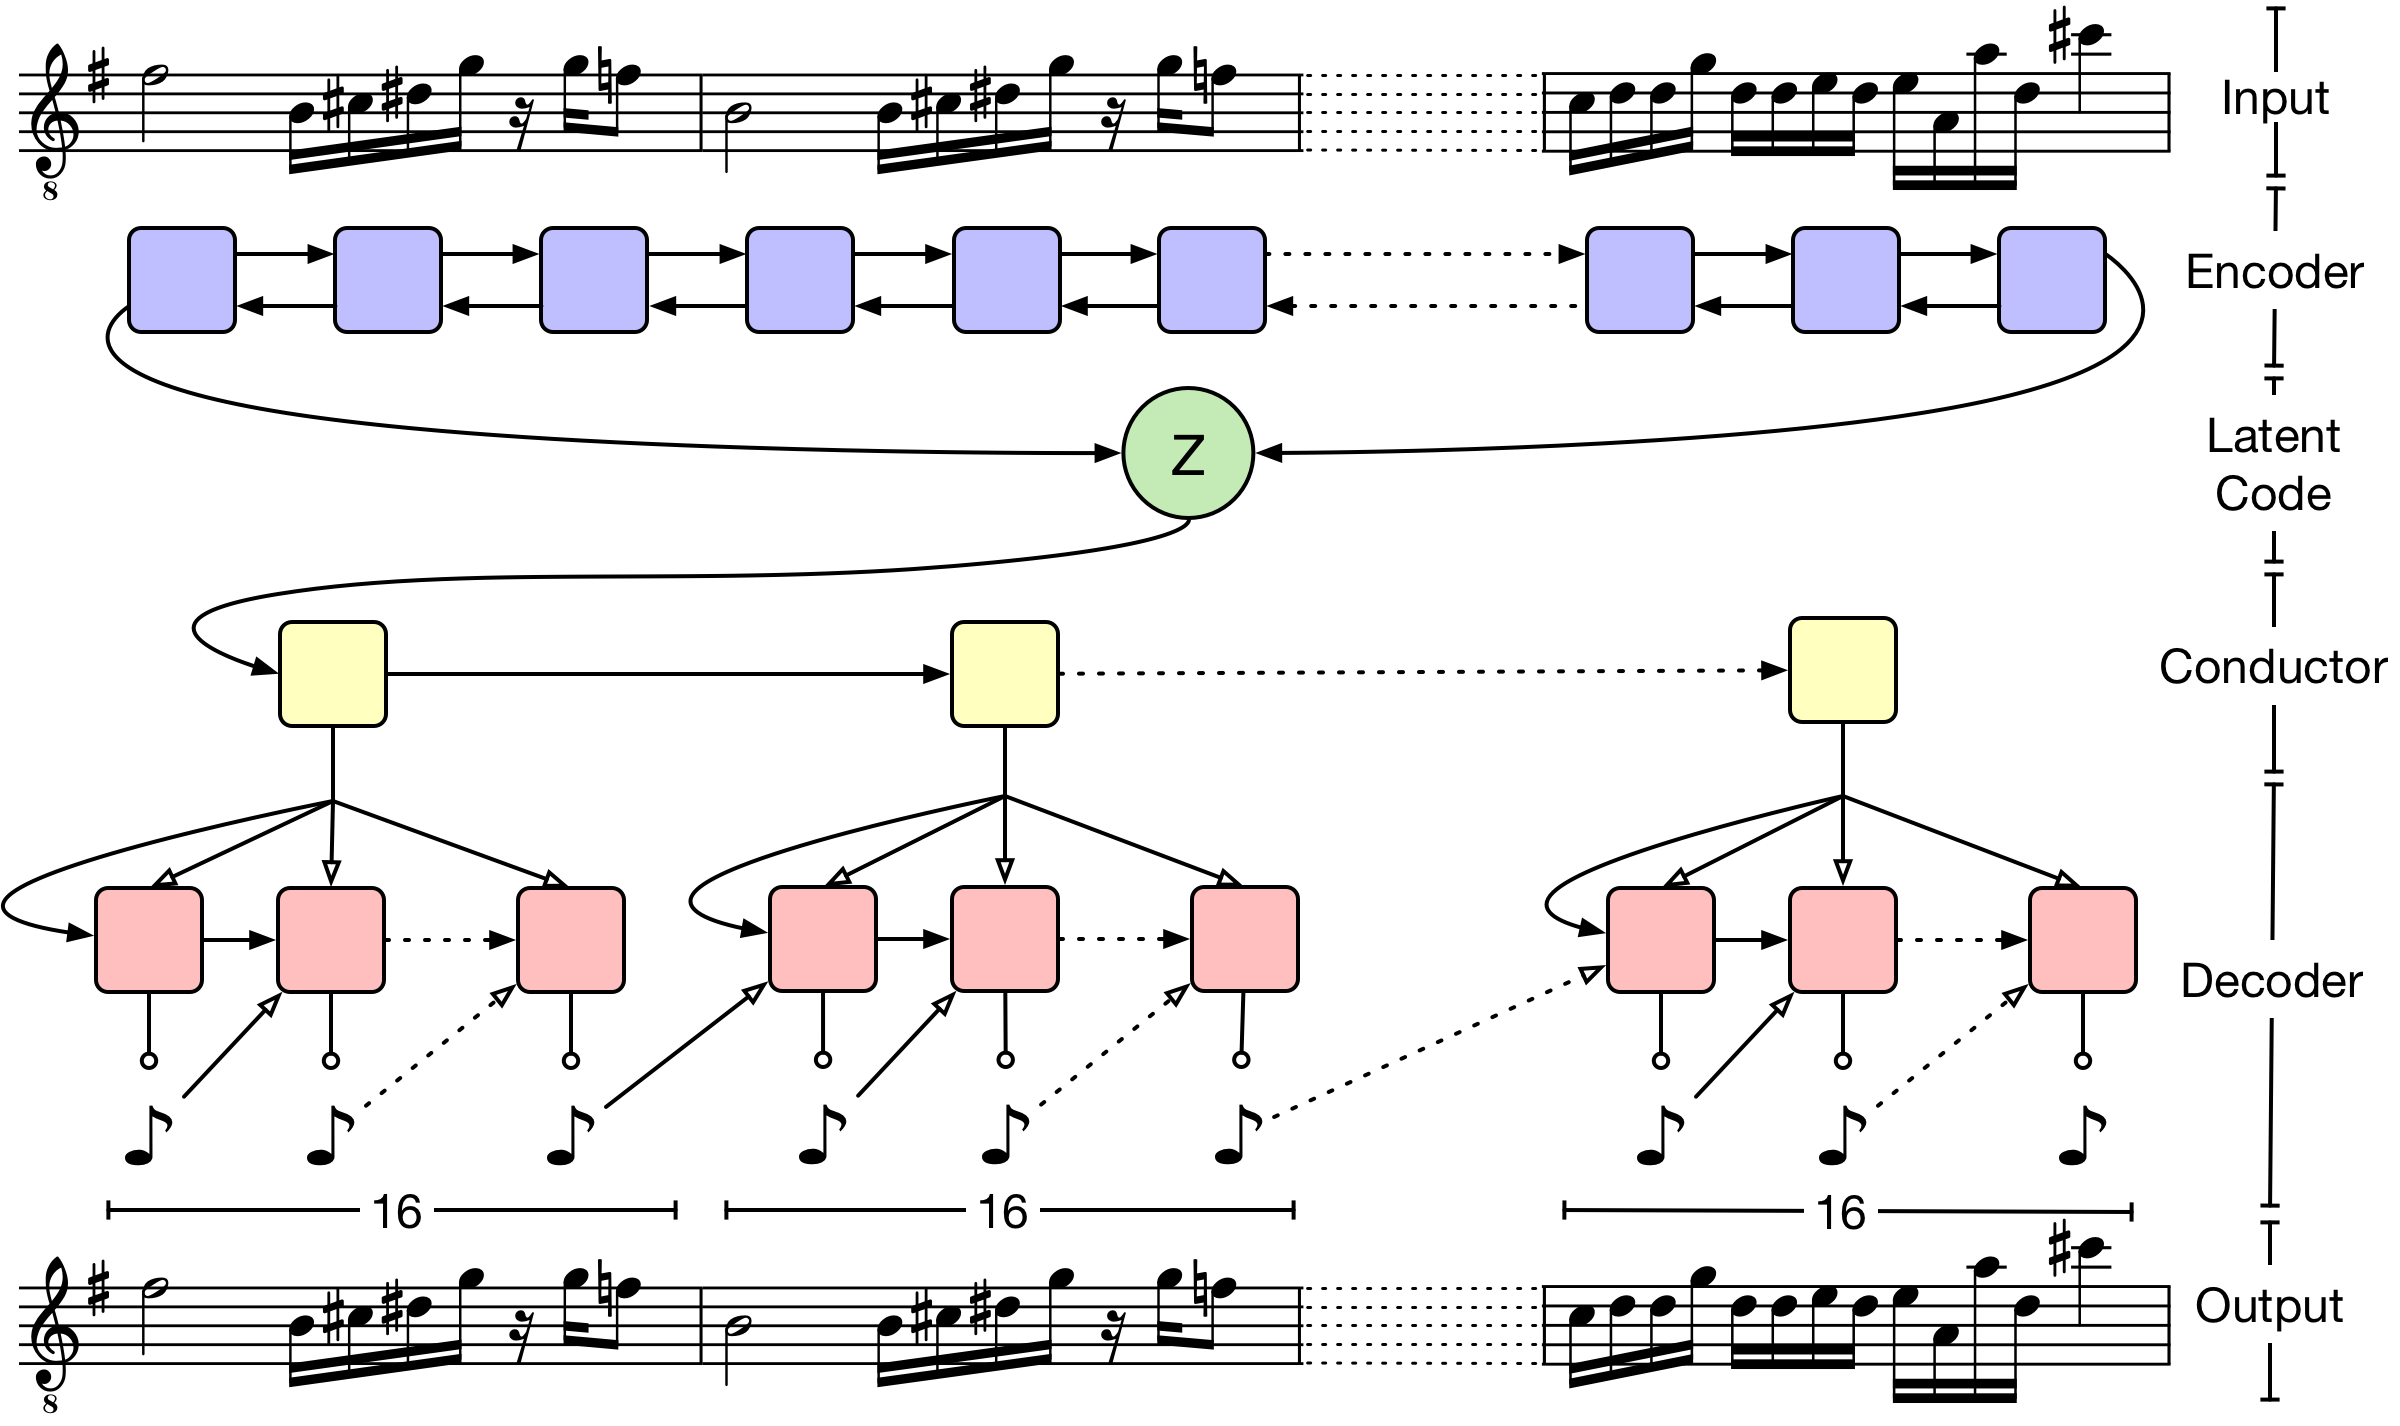

* Encoder = Bidirectional Encoder
    * 2-layer Bidirectional LSTM
    * hidden state size = 2048
    * latent dimensions = 512
* latent code
    * 선형보간 방식으로 계산    
        \begin{align}
        c_α = αz_1+(1-α)z_2
        \end{align}
* Decoder = Hierarchical Decoder
    * 2-layer unidirectional LSTM
    * hidden state size = 1024
    * output dimensions = 512

# 3. 전처리

In [26]:
# tfrecord로 변환
convert_directory(ROOT_PATH,RECORD_PATH,recursive=True)
clear_output()

### 전처리 분석
#### Hyperparameter
```
batch_size=512,
max_seq_len=16 * 4,  # 4 bars w/ 16 steps per bar
z_size=256,
enc_rnn_size=[512],
dec_rnn_size=[256, 256],
max_beta=0.2,
free_bits=48,
dropout_keep_prob=0.3,
```
#### Converter
```
data.GrooveConverter(
split_bars=4, steps_per_quarter=4, quarters_per_bar=4,
max_tensors_per_notesequence=20,
pitch_classes=data.ROLAND_DRUM_PITCH_CLASSES,
inference_pitch_classes=data.REDUCED_DRUM_PITCH_CLASSES)
```
* ROLAND_DRUM_PITCH_CLASSES
```
[[36],
 [38, 37, 40],
 [42, 22, 44],
 [46, 26],
 [43, 58],
 [47, 45],
 [50, 48],
 [49, 52, 55, 57],
 [51, 53, 59]]
```
* ROLAND_DRUM_PITCH_CLASSES
```
[[36, 35],
 [38, 27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85],
 [42, 44, 54, 68, 69, 70, 71, 73, 78, 80, 22],
 [46, 67, 72, 74, 79, 81, 26],
 [45, 29, 41, 43, 61, 64, 84],
 [48, 47, 60, 63, 77, 86, 87],
 [50, 30, 62, 76, 83],
 [49, 52, 55, 57, 58],
 [51, 53, 59, 82]]
```

# 4. 실행

## 4-1. 사전학습 모델 불러오기

In [27]:
# GrooVAE configs에 tfrecord 경로 추가, tfds_name 삭제
new_pre_config = update_config(configs.CONFIG_MAP['groovae_4bar'],{'train_examples_path':RECORD_PATH,'tfds_name':None})

In [28]:
model = TrainedModel(
    config=new_pre_config,
    batch_size=1,
    checkpoint_dir_or_path='./groovae_4bar.tar') # 체크포인트의 경로

/usr/local/lib/python3.8/dist-packages/magenta/models/music_vae/lstm_utils.py:94: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  tf.layers.dense(
/usr/local/lib/python3.8/dist-packages/magenta/contrib/rnn.py:750: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._kernel = self.add_variable(
/usr/local/lib/python3.8/dist-packages/magenta/models/music_vae/base_model.py:195: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mu = tf.layers.dense(
<ipython-input-28-e8ba1347fe89>:1: ResourceWarning: unclosed file <_io.BufferedReader name='./groovae_4bar.tar'>
  model = TrainedModel(


## 4-2. MIDI 생성

In [29]:
generated_sequence = model.sample(n=5, length=new_pre_config.hparams.max_seq_len, temperature=0.5)
result_path = []
for i in range(5):
    if os.path.exists(RESULT_PATH) == False:
        os.makedirs(RESULT_PATH, exist_ok=True)

    result_path.append(f'{RESULT_PATH}generate_drum_{i}.mid')
    note_seq.sequence_proto_to_midi_file(generated_sequence[i], f'{RESULT_PATH}generate_drum_{i}.mid')

/usr/local/lib/python3.8/dist-packages/note_seq/midi_io.py:207: ResourceWarning: unclosed file <_io.BufferedWriter name='./result/generate_drum_0.mid'>
  pretty_midi_object.write(open(output_file, 'wb'))
/usr/local/lib/python3.8/dist-packages/note_seq/midi_io.py:207: ResourceWarning: unclosed file <_io.BufferedWriter name='./result/generate_drum_1.mid'>
  pretty_midi_object.write(open(output_file, 'wb'))
/usr/local/lib/python3.8/dist-packages/note_seq/midi_io.py:207: ResourceWarning: unclosed file <_io.BufferedWriter name='./result/generate_drum_2.mid'>
  pretty_midi_object.write(open(output_file, 'wb'))
/usr/local/lib/python3.8/dist-packages/note_seq/midi_io.py:207: ResourceWarning: unclosed file <_io.BufferedWriter name='./result/generate_drum_3.mid'>
  pretty_midi_object.write(open(output_file, 'wb'))
/usr/local/lib/python3.8/dist-packages/note_seq/midi_io.py:207: ResourceWarning: unclosed file <_io.BufferedWriter name='./result/generate_drum_4.mid'>
  pretty_midi_object.write(open(

### 결과 시각화

In [30]:
for i in result_path:
    visualization_midi(i)

## 4-3. Wav로 변환

In [31]:
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
for full_name in result_path:
    split_path = os.path.split(full_name)
    file_name = f'{split_path[0]}/{split_path[1][:-4]}'
    os.system(f'fluidsynth -ni font.sf2 {full_name} -F {file_name}.wav -r 44100')

생성된 wav 파일은 `/result/wav/`에서 확인가능합니다.